In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from scipy.optimize import curve_fit

In [101]:
# Parquet filepaths
filepath_CryoU238  = "/home/hargy/output1.parquet"
filepath_CryoTh232 = "/home/hargy/output2.parquet"

# DataFrames
df_CryoU238  = pd.read_parquet(filepath_CryoU238)
df_CryoTh232 = pd.read_parquet(filepath_CryoTh232)

In [178]:
def exp_decay(x, a, b):
    return a * np.exp(-x/b)

def get_unique_events(df):
    return np.unique(df.loc[:, 'event'].to_numpy())

def get_event_df(df, event_num):
    return df[df['event'] == event_num]

def visualise_event(df, event_num):
    event_df = get_event_df(df, event_num)
    
    xp_pri = event_df.loc[:, 'xp_pri'].to_numpy()[0]
    yp_pri = event_df.loc[:, 'yp_pri'].to_numpy()[0]
    zp_pri = event_df.loc[:, 'zp_pri'].to_numpy()[0]
    
    xp = event_df.loc[:, 'xp'].to_numpy()
    yp = event_df.loc[:, 'yp'].to_numpy()
    zp = event_df.loc[:, 'zp'].to_numpy()

    edep = event_df.loc[:, 'edep'].to_numpy()

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    for cluster, z in enumerate(zp):
        ax1.scatter(xp[cluster], z, s = 30, label = f'{int(edep[cluster])} keV')

    ax1.scatter(xp_pri, zp_pri, c='red', marker='x', s=100, label='Primary Vertex')
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('z [mm]')

    # Box limits
    x_min, x_max = -1500, 1500
    y_min, y_max = -1575, 1575

    # Add shaded rectangle
    rect = Rectangle(
        (x_min, y_min),           # bottom-left corner
        x_max - x_min,            # width
        y_max - y_min,            # height
        facecolor="magenta",         # or any color
        alpha=0.2,
        edgecolor=None
    )
    ax1.add_patch(rect)

    ax1.legend(loc='upper right')
    ax1.set_xlim(-1700, 1700)
    ax1.set_ylim(-2000, 2000)

    for cluster, y in enumerate(yp):
        ax2.scatter(xp[cluster], y, s = 30, label = f'{int(edep[cluster])} keV')

    ax2.scatter(xp_pri, yp_pri, c='red', marker='x', s=100, label='Primary Vertex')
    ax2.set_xlabel('x [mm]')
    ax2.set_ylabel('y [mm]')

    # Circle parameters
    x0, y0 = 0, 0        # center
    r = 1500              # radius

    circle = Circle(
        (x0, y0),        # center
        r,               # radius
        facecolor="magenta",
        alpha=0.2,
        edgecolor="black"   # or None
    )
    ax2.add_patch(circle)

    ax2.legend(loc='upper right')
    ax2.set_xlim(-1700, 1700)
    ax2.set_ylim(-1700, 1700)
    
    plt.tight_layout()
    return None
    

def visualise_all_clusters(df, title="Cluster Spatial Distribution"):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

    xp = df.loc[:, 'xp'].to_numpy()
    yp = df.loc[:, 'yp'].to_numpy()
    zp = df.loc[:, 'zp'].to_numpy()

    xp_pri = df.loc[:, 'xp_pri'].to_numpy()
    yp_pri = df.loc[:, 'yp_pri'].to_numpy()
    zp_pri = df.loc[:, 'zp_pri'].to_numpy()

    ax1.scatter(xp, yp, s = 0.25, label = 'Clusters')
    ax1.scatter(xp_pri, yp_pri, c='red', marker='x', s=0.5, alpha=0.3, label = 'Primaries')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')  

    ax2.scatter(xp, zp, s = 0.25, label = 'Clusters')
    ax2.scatter(xp_pri, zp_pri, c='red', marker='x', s=0.5, alpha=0.2, label = 'Primaries')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('x [mm]')
    ax2.set_ylabel('z [mm]')  
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def get_cluster_distances(df):
    event_ids = get_unique_events(df)
    distances = []
    for id in event_ids:
        event_df = get_event_df(df, id)
        zp = event_df.loc[:, 'zp'].to_numpy()
        diffs = np.diff(zp)
        distances.extend(diffs)
    return distances

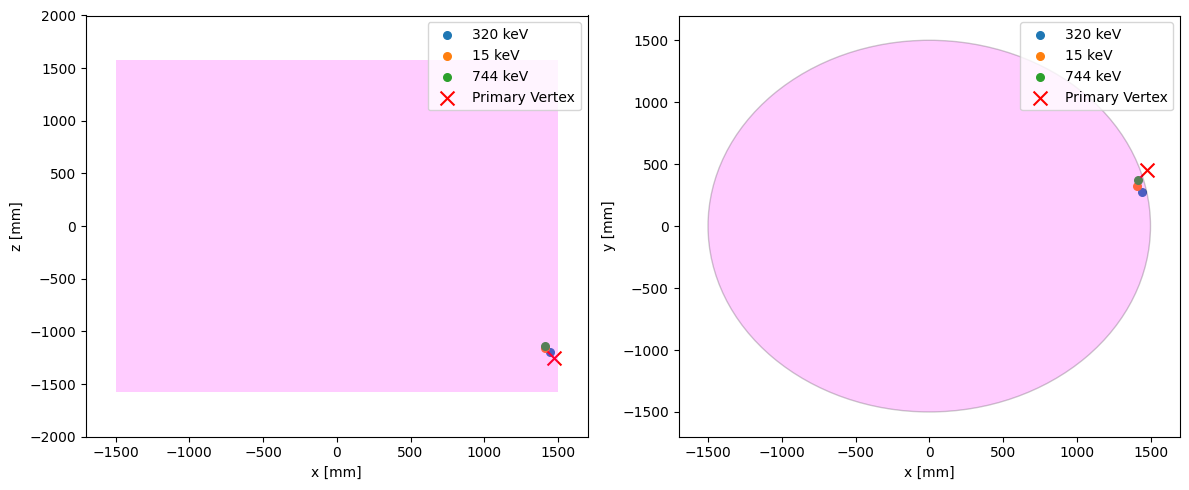

In [188]:
visualise_event(df_CryoU238, 223)

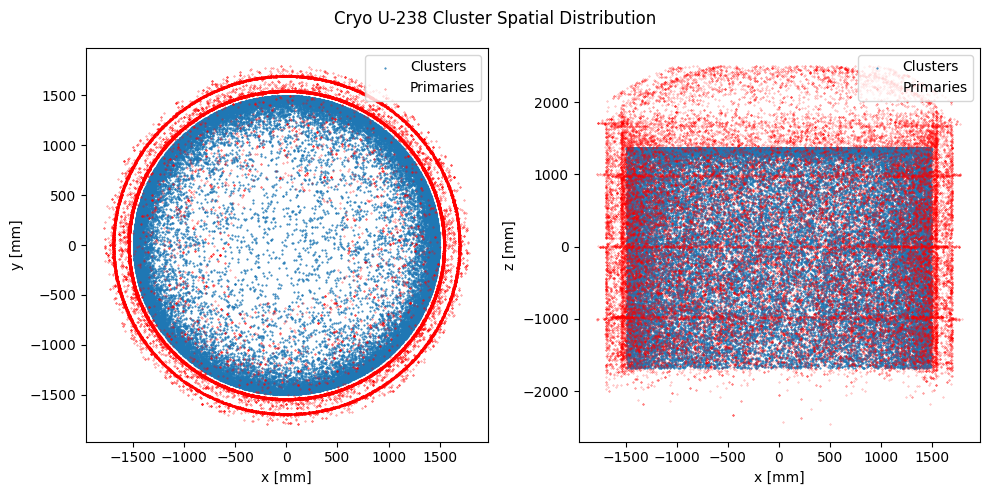

In [143]:
visualise_all_clusters(df_CryoU238, title="Cryo U-238 Cluster Spatial Distribution")

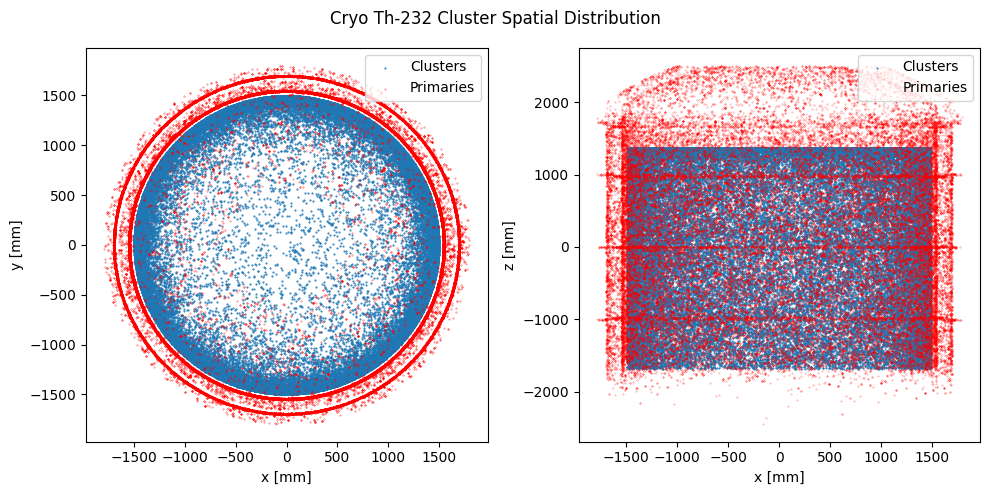

In [145]:
visualise_all_clusters(df_CryoTh232, title="Cryo Th-232 Cluster Spatial Distribution")

In [ ]:
distances_U238  = get_cluster_distances(df_CryoU238)
distances_Th232 = get_cluster_distances(df_CryoTh232)

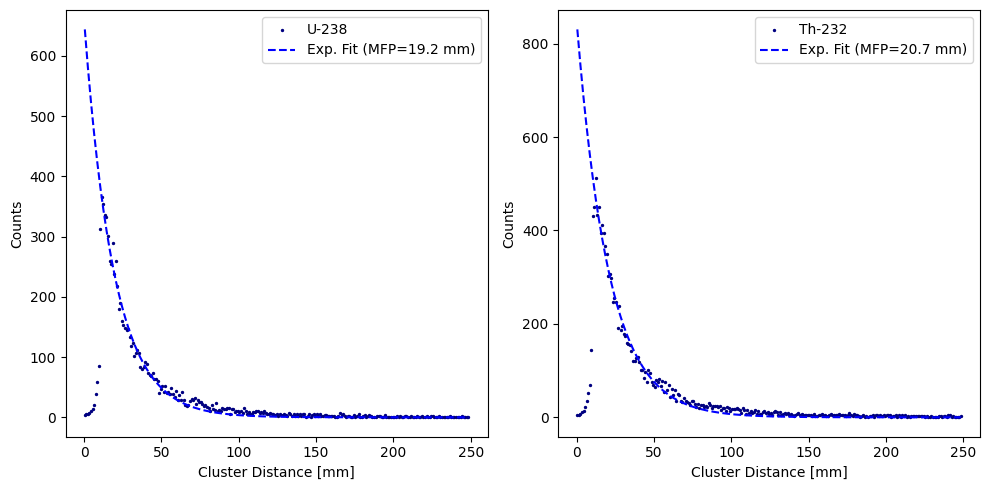

In [184]:
bins = np.arange(0, 250, 1)
bin_mids = 0.5 * (bins[1:] + bins[:-1])
cut = 11

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

hist, bin_edges = np.histogram(distances_U238, bins=bins)
popt, _ = curve_fit(exp_decay, bin_mids[cut:], hist[cut:], p0=(1e3, 10))
meanfree =  popt[1]

ax1.scatter(bin_mids, hist, color='navy', label='U-238', s=2)
ax1.plot(bin_mids, exp_decay(bin_mids, *popt), color='blue', linestyle='--', label=f'Exp. Fit (MFP={meanfree:.1f} mm)')
ax1.set_xlabel('Cluster Distance [mm]')
ax1.set_ylabel('Counts')
ax1.legend()


hist, bin_edges = np.histogram(distances_Th232, bins=bins)
popt, _ = curve_fit(exp_decay, bin_mids[cut:], hist[cut:], p0=(1e3, 10))
meanfree =  popt[1]

ax2.scatter(bin_mids, hist, color='navy', label='Th-232', s=2)
ax2.plot(bin_mids, exp_decay(bin_mids, *popt), color='blue', linestyle='--', label=f'Exp. Fit (MFP={meanfree:.1f} mm)')
ax2.set_xlabel('Cluster Distance [mm]')
ax2.set_ylabel('Counts')
ax2.legend()
plt.tight_layout()